CNN - TRAFFIC SIGNS

This project aims to classify traffic signs using a convolutional neural network (CNN). The dataset contains labelled images of traffic signs, each corresponding to a specific class. Labels are loaded from a CSV file, which maps image identifiers to their class names, ensuring easy association between the images and their respective categories.

In [1]:
# Importing the pandas library
import os
import pandas as pd 

#Defining the file path
file_path = "data/labels.csv"

# Reading the csv file
filename_read = os.path.join(file_path, "data/labels.csv")
df = pd.read_csv(filename_read)
print(df)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

/var/folders/ww/wx0kw6d17ml1bkwwfxpdjs0c0000gn/T/ipykernel_26136/1860504946.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Below I add a visualisation of dataset as a Bar graph to show the dataset is complete by stating any ClassId is missing or mislabeled so that it is easily identifiable.
the observations got were that ClassId had the correct labels with it, the dataset has a balanced distribution as no overlapping and duplicate bars are present.

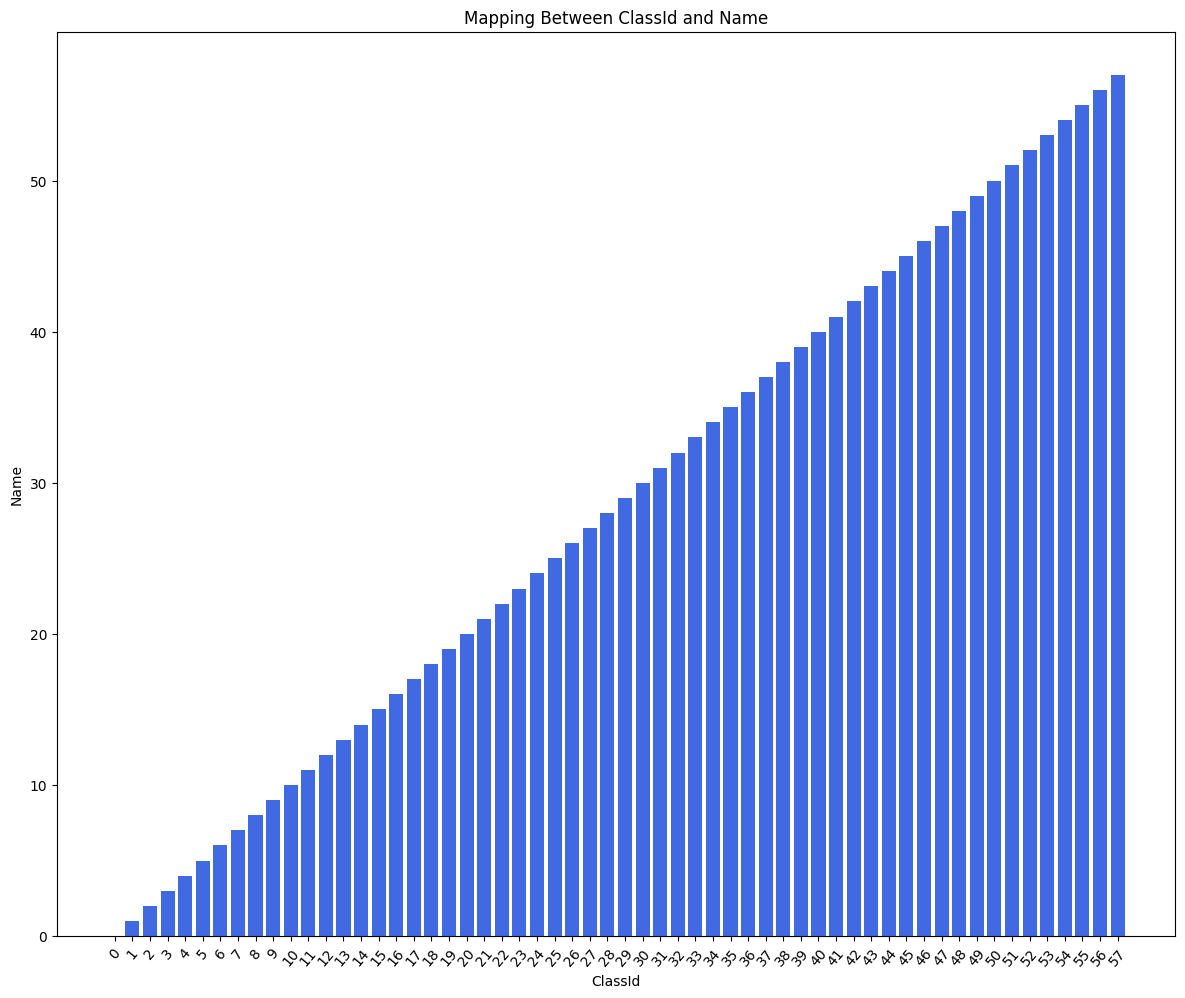

In [28]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt

# Loading  the dataset
file_path = 'data/labels.csv'  # Update the path to your file
df = pd.read_csv(file_path)

# Plotting ClassId and Name mapping
plt.figure(figsize=(12, 10))
plt.bar(df['ClassId'], df['ClassId'], color='royalblue')
plt.title("Mapping Between ClassId and Name")
plt.xlabel("ClassId")
plt.ylabel("Name")
plt.tight_layout()  
plt.xticks(df['ClassId'], rotation=50)
plt.show()

After importing the pytorch libraries, I proceed with the preprocessing of images by resizing it to 32X32 pixels for uniformity across the dataset. Then I transform each image to a tensor and normalize it from scale -1 to 1 which drastically improves the training by ensuring the input data has mean of 0 and a standard deviation of 1.

I load the Augmented DATA image dataset with each folder representing a class and the name as a label and I preprocess it for loading.

the dataset is then split into training-validation-test sets using random as it preserves the dataset sizes. The training set is split 70% of the data (optimizing the model’s weights). The validation set is split 15% (model"s performance during traing). The test set is split 15% (tunes model’s generalization ability).
For maximum efficiency of memory usage I have set the batch size to 32 while loading the sets.

For better understanding of the image dataset I plot it on first 3 images with their class labels. The class labels are displayed as titles to provide context for each image which makes the  visualization step check the correctness of the data loading and transformation process.

The visualization of images prepares for the training process.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.88235295].


Number of classes: 58
Train size: 5800
Validation size: 2900
Test size: 2900
11600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.5372549].


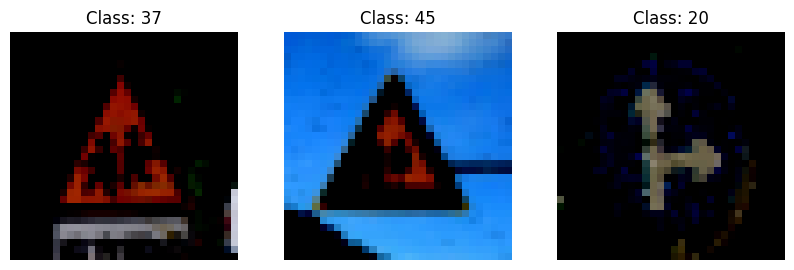

In [46]:
# CNN Implementation in pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim 
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
torch.manual_seed(42)


# transformation 
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='data/traffic_Data/DATA', transform=transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# train test split
train_size = int(0.5 * len(dataset)) # 50
val_size = int(0.25 * len(dataset)) # 25
test_size = len(dataset) - train_size - val_size #25
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator= torch.Generator().manual_seed(42))
print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)
print(train_size + val_size + test_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sample of images 
def samples(images, labels, class_names):
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):  
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())  
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# first 3 images
samples(images[:3], labels[:3], dataset.classes)




Below I define the CNN Model class which inherits the pytorch module, making it structural and modular for training.
I define three convolutional layers:
The first layer processes the 3-channel RGB input with 32 filters of size 3x3.
The next two layers increase the number of filters to 64 and 128, capturing more complex patterns at each stage.
Padding of 1 ensures the output spatial dimensions remain consistent after convolution.
The max pooling layer is 2X2 to downsize the feature maps by half. Next, I flatten the maps to 128*4*4 for a dense mapping with 512 neurons.
Dropout layers are added to reduce overfitting by half.

In the Forward Pass, each layer is passed by a ReLu activation function compared to others as it outputs 0 for negative inputs and speeds the training in dense networks.
I have also added view for flattening it from 2D maps to 1D vector.
The CNN constructor adjusts the output layer to match the dataset’s classes, ensuring compatibility regardless of the number of categories.



In [47]:
# CNN MODEL CLASS
class CNN(nn.Module):
    def __init__(self, number_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.c1 = nn.Linear(128 * 4 * 4, 512)  
        self.dropout = nn.Dropout(0.5)
        self.c2 = nn.Linear(512, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.c1(x))
        self.dropout = nn.Dropout(0.5)
        x = self.c2(x)
        return x

In the Training Model, each epoch completes one round over training and validation phases.
The images and labels are put into batches as it optimizes the memory and are passed through the model to give prediction for each image.
the loss function tracks the difference in predictions and labels so I compute the gradient for the loss and the parameters are optimized.
The running loss is used to calculate the average training loss later on.
I specifically used zero_grad as my optimizer as it provides with each batch gradient computation and gradients from previous batches do not interfere with the current batch.

In the Validation step, I switch off the gradient descent with no_grad reducing memory usage. The validation dataset loaded in batches is passed through the model to generate predictions and for each batch the loss is calculated.
i did use torch.max to normalize the scores for each class.
Based on our predictions with the labels I calculate the accuracy.

I go on to print the metrics for each epoch and the call the training model.

I use three optimizers named Adam, SGD, and RMSProp to evaluate the performance of the model and with that I loop each optimizer through their key value pair of name and function and print it.
After creating a instance of the CNN class, I reinitialize for each optimizer so a new optimizer must be initialized for each training run.
- 0.01 for SGD, along with the momentum hyperparameter set to 0.9.
- 0.001 for Adam and RMSprop.

The Cross Entropy loss funtion helps to convert the c2 layer high probabilities to classes as it combines the log-softmax and negative log into a single log function.



In [48]:
# Train model for each epoch
def training_model(model, train_loader, val_loader, criteria, optimizer, optimizer_name, epochs=6):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criteria(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Optimizer: {optimizer_name}, Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {100 * correct / total:.2f}%")

# Define multiple optimizers
optimizer = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}

# Looping through each optimizer
for optimizer_name, optimizer_function in optimizer.items():
    print(f"\nTraining with Optimizer: {optimizer_name}")

    # Reinitializing the model
    model = CNN(number_classes=num_classes)

    # Initialize the optimizer
    if optimizer_name == 'SGD':
        optimizer = optimizer_function(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optimizer_function(model.parameters(), lr=0.001)

    # loss function
    criteria = nn.CrossEntropyLoss()

    # Training the model
    training_model(model, train_loader, val_loader, criteria, optimizer, optimizer_name, epochs=6)




Training with Optimizer: Adam
Optimizer: Adam, Epoch 1/6, Train Loss: 2.4496, Validation Loss: 1.2745, Validation Accuracy: 63.24%
Optimizer: Adam, Epoch 2/6, Train Loss: 0.7336, Validation Loss: 0.5414, Validation Accuracy: 84.24%
Optimizer: Adam, Epoch 3/6, Train Loss: 0.3202, Validation Loss: 0.4259, Validation Accuracy: 88.66%
Optimizer: Adam, Epoch 4/6, Train Loss: 0.1910, Validation Loss: 0.2761, Validation Accuracy: 92.28%
Optimizer: Adam, Epoch 5/6, Train Loss: 0.1237, Validation Loss: 0.2958, Validation Accuracy: 92.31%
Optimizer: Adam, Epoch 6/6, Train Loss: 0.0984, Validation Loss: 0.2175, Validation Accuracy: 93.97%

Training with Optimizer: SGD
Optimizer: SGD, Epoch 1/6, Train Loss: 3.8419, Validation Loss: 2.9820, Validation Accuracy: 22.24%
Optimizer: SGD, Epoch 2/6, Train Loss: 2.0771, Validation Loss: 1.3038, Validation Accuracy: 63.28%
Optimizer: SGD, Epoch 3/6, Train Loss: 0.9841, Validation Loss: 0.8099, Validation Accuracy: 77.62%
Optimizer: SGD, Epoch 4/6, Train 

So now I evaluate the model based on Test performance, Classification report and Confusion matrix. 
Once I Initialize the metrics I turn torch.no_grad off so I don’t waste memory and computation on gradient computation as I don’t use gradients for evaluation. 
torch.max : torch.max allows me to map the output logits to class labels by choosing maximum value index per sample and setting metrics. 
Then I take the Test success and Classification report. 
the Classification report gives me  
- Accuracy: How many items selected matter? 
- Recall: How many related items are chosen? 
- F1-Score: Ratio of accuracy and recall. 
- Support: No of real samples per class. 

Last I generate the Confusion matrix using 12X12 heat map where I highlight misclassifications between classes and objects. 
patterns on model predictions.


Test Accuracy: 90.17%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86        55
           1       0.85      0.89      0.87        45
          10       1.00      0.93      0.97        45
          11       0.88      1.00      0.93        43
          12       0.98      0.98      0.98        48
          13       1.00      0.88      0.93        48
          14       0.95      0.83      0.88        46
          15       0.98      0.93      0.95        54
          16       0.98      0.81      0.89        54
          17       0.75      0.94      0.83        47
          18       1.00      1.00      1.00        50
          19       0.83      1.00      0.91        59
           2       1.00      0.65      0.79        49
          20       1.00      0.98      0.99        45
          21       0.98      1.00      0.99        50
          22       1.00      1.00      1.00        49
          23       1.00      1.00  

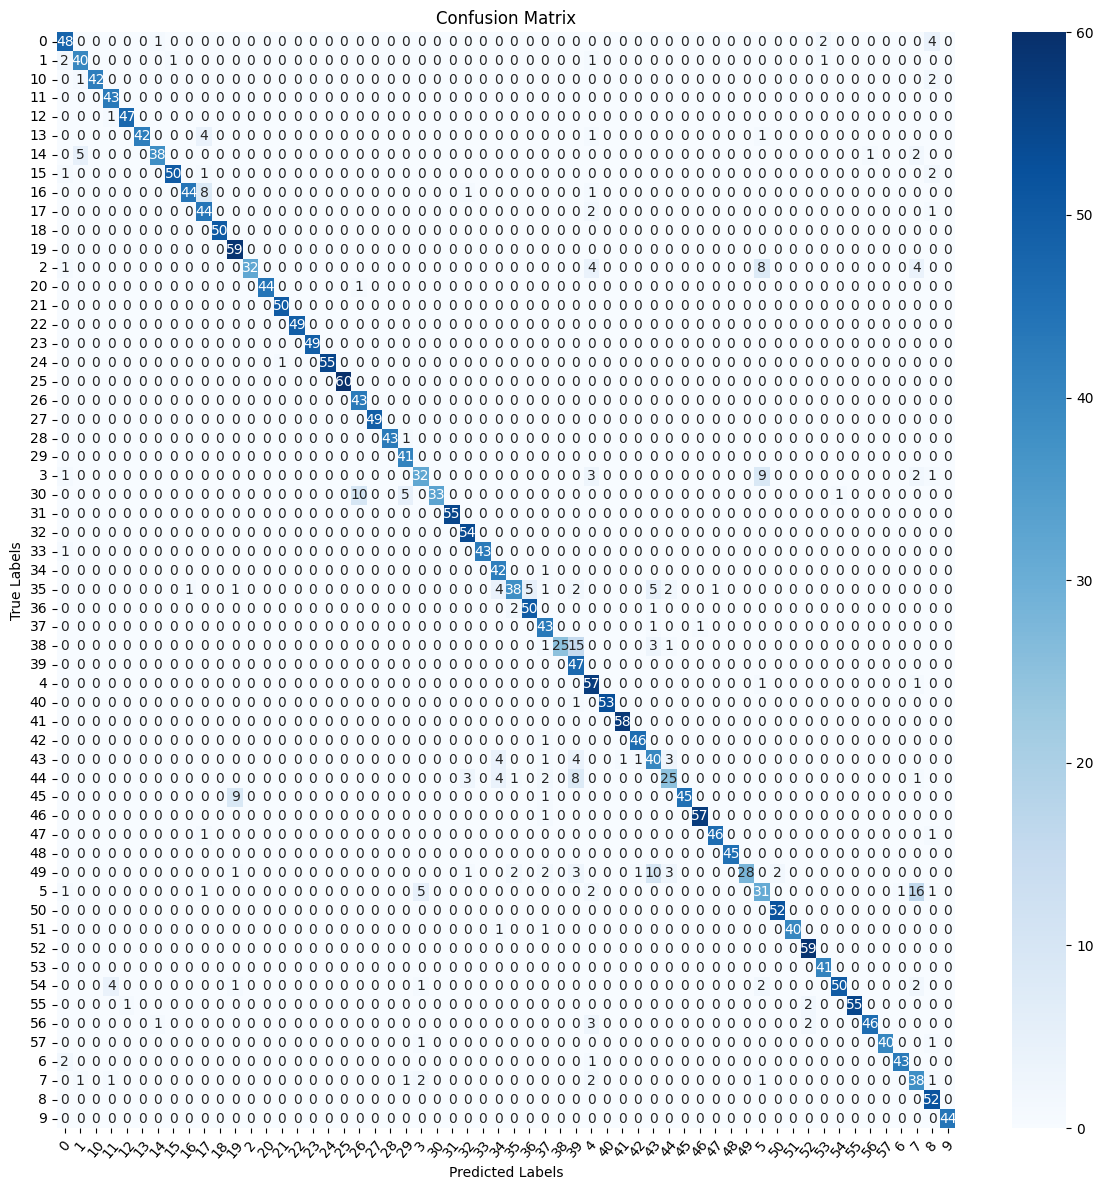

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation_model(model, test_loader, classes):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # accuracy score
    accuracy_score = 100 * correct / total
    print(f"Test Accuracy: {accuracy_score:.2f}%")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=classes))
    
    # Confusion matrix
    matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 12))
    sns.heatmap(matrix, fmt='d', annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=50)
    plt.tight_layout()
    plt.show()


evaluation_model(model, test_loader, dataset.classes)

Saving the model.

In [50]:
# save the model
torch.save(model, 'model.pth')
print('Saved trained model')

Saved trained model
